# Notebook 1.1: Experimenting with Hash Tables

Before completing this notebook you should have completed your assigned reading, chapters 10.1 & 10.2 of [Data Structures and Algorithms in Python (Goodrich, Tamassia, & Goldwasser)](https://www.wiley.com/en-us/Data+Structures+and+Algorithms+in+Python%2C+1st+Edition-p-9781118290279), which includes text about Hash Functions, Collision-Handling Schemes, & Load Factors.

Storing and retrieving data is a fundamental operation in computer science. Hash tables are a very practical and efficient data structure for storing *key*:*value* pairs, and python implements this data structure with the `dict` class. As you advance in your career as a computer scientist, if you code in python you will make significant use of the python dictionaries, so it's important to understand the details of how they work.

Follow along with the materials and execute code in this notebook to get a better understanding of the inner workings of **hash
functions**, which underly this ubiquitous data structure.


In [311]:
# As usual, start by loading required libraries
import matplotlib.pyplot as plt
import numpy as np

## Understanding properties of 'useful' hash functions

Recall from the reading that a *hash function* *h(k)* comprises two components:  
- A **hash code** that maps a key *k* to an integer, and
- A **compression function** that maps the hash code to an integer ([0, N-1]) for indexing into
our bucket array (of size *N*).

A very simple compression function is `mod N` (in python `% N`), and for the purpose of this exercise
that is what we will adopt, since we are focused on hashing for the moment.

Useful hash functions should strive for these properties:  
1. They should be deterministic
2. They should be efficient to compute
3. They should produce uniformly distributed hash values

In practice, the requirement of **determinism** is an 'iron rule' rather than a feature we can optimize over. Imagine using a hash table
to store your contact info. If your contacts hash table implemented a non-deterministic hash function you might look up the phone number for your mother and get returned the number for your childhood best friend! Not the worst case scenario, but definitely not 'the desired effect'™.

On the other hand, **efficiency** of computation and **uniformity** of distribution of hash values **are** features we can optimize over. One could imagine a very very efficient hash function with poor distribution of hash values (many collisions), or a very computationaly expensive hash function with perfect uniformity of distribution. Consider situations where one of these might have an advantage over the other.

*"There are no solutions. There are only trade-offs."*  
― Thomas Sowell, [A Conflict of Visions: Ideological Origins of Political Struggles](https://en.wikipedia.org/wiki/A_Conflict_of_Visions)

In this exercise we will explore the **efficiency**/**uniformity** tradeoff for a number of different 'cartoon' hash functions, so you can get the feel for what this means.

## Set up the input data

For this exercise we will use strings of text as the input data. We'll tokenize the strings (delimiting on
whitespace), compute hash functions for each word in the string, and evaluate runtime and hash value distributions.
We will use: a couple of choice nuggets from Knuth's magnum opus [The Art of Computer Programming](https://en.wikipedia.org/wiki/The_Art_of_Computer_Programming); a [*Lorem ipsum*](https://en.wikipedia.org/wiki/Lorem_ipsum) generator (for longer blocks of pseudo-random text); and a batch of uniformly distributed random integer values from numpy.

In [335]:
from lorem_text import lorem

# The Art of Computer Programming, Vol. I
quote1 = """People who are more than casually interested in computers should 
have at least some idea of what the underlying hardware is like. Otherwise the programs 
they write will be pretty weird.""".split()

# The Art of Computer Programming, Vol III
quote2 = """It is especially important to know the average behavior of a hashing method, 
because we are committed to trusting in the laws of probability whenever we hash. 
The worst case of these algorithms is almost unthinkably bad, so we need to be 
reassured that the average is very good.""".split()

# Random nonsense text
lorem_text = lorem.paragraphs(1).split()

# Random integer values
randint_data = np.random.randint(0, 10000, 1000)

## Candidate hash functions

Here are several examples of functions that satisfy the definition of *hash codes* as proposed by the text,
i.e. a map between an input *key* and an integer value. I have isolated the hash codes here from the 
compression function (`% N`), but we'll pull this back in later when we implement the `my_hasher()` class,
to allow for flexibility in this size of the hash table index.

Think about how these functions will perform in terms of the 'useful properties' we discussed: Determinism, 
efficiency, & uniformity. Discuss with a partner which of these you think will perform 'best' overall, and 
why you think this. Be prepared to share with the class, and justify your choice.

In [355]:
def hash_one(data):
    """For any input data return the integer 1"""
    return 1

def hash_random(data):
    """For any input data return a random integer [0, 100)"""
    return np.random.randint(100)

def hash_length(data):
    """Return the length (character count) of the input sequence"""
    # Cast to a string to allow passing in numerical values
    data = str(data)
    return len(data)

def hash_first(data):
    """Return the Unicode code point (integer value) of the first character of input"""
    # Cast to a string to allow passing in numerical values
    data = str(data)
    # `ord()` is a python built-in to get the integer value of a
    # single-character string
    return ord(data[0])

def hash_sum(data):
    """Return the sum of Unicode integer values of all characters of input"""
    data = str(data)
    return sum([ord(x) for x in data])

## Simple experiments with hash functions
Now spend some time testing your hypotheses about the behaviors of some of these hash functions using
the `quote1`, `quote2`, `lorem_text`, and `randint_data` variables we created previously. A very simple and
quick way to apply these functions to lists of items is to use *list comprehension*, and then you might
consider using `Counter` from the python `collections` library, to count the number of occurrences of each
hash value. (**NB:** `collections.Counter` is a sub-class of `dict`, as it stores key/values pairs as well!) 

In [372]:
from collections import Counter

hashed = [hash_first(x) for x in quote2]
Counter(hashed)

Counter({116: 9,
         97: 6,
         105: 5,
         119: 5,
         98: 4,
         111: 3,
         104: 2,
         99: 2,
         73: 1,
         101: 1,
         107: 1,
         109: 1,
         108: 1,
         112: 1,
         84: 1,
         117: 1,
         115: 1,
         110: 1,
         114: 1,
         118: 1,
         103: 1})

## Define the `my_hasher()` class as a test harness

Because this is a teaching demonstration (and not the middle of an actual semester where we'd have been 
working together for weeks), I can't make assumptions about the python coding expertise of any given 
participant. But, because you all have CS backgrounds or are at least CS-adjacent, I hope it's fair to 
assume that I can expect you to be able to 'plug-and-chug' with a pre-baked test harness for evaluating
hash function behavior.

If you don't know python or are relatively new to coding, don't worry about the details of this class. 
You'll see how to pull the levers below, and it should be quite straightforward. Execute the next cell
to define this class.

In [341]:
# We will use the `entropy()` function from scipy.stats to quantify
# uniformity of distribution of hash values, so import it here.
from scipy.stats import entropy

class my_hasher:
    """A simple class to wrap and evaluate hash function performance."""

    def __init__(self, size=10, hash_method=hash):
        """
        Parameters:
            size (int): The size of the hash table index
            hash_method (function): The hash code to apply (defaults to python `hash`).
        """
        self.size = size
        # A list for counting the number of collisions at a given index
        self.indices = [0] * size
        self.hash_method = hash_method

    def hash_data(self, data=[0,1,2,3,4,5,6,7,8,9]):
        """
        Apply the hash function (hash code plus compression) to each element 
        of the input data, and accumulate the number of 'hits' to a given index.

        Parameters:
            data (list): A list of elements to which the function will be applied.
                         List items must be strings or numerical.
        """
        for item in data:
            # Apply the hash function to each item
            hash_val = self.hash_method(item) % self.size
            self.indices[hash_val] += 1

    def evenness(self):
        """
        A simple way to quantify uniformity using information theory.

        Returns:
            A value between 0 and 1 (inclusive) representing the
            evenness of the distribution of hashes among the array bins.
            Values closer to 1 are more even.
        """
        return np.exp(entropy(self.indices))/self.size

    def plot(self):
        plt.bar(range(self.size), self.indices)


### Simple-as-possible execution to demonstrate `my_hasher` class

We gave the `__init__()` and `hash_data()` methods sensible and simple
defaults, so we can create a new `my_hasher` object, hash some data, and plot the results
pretty frictionlessly to demonstrate the workflow.

np.float64(0.5000000000000001)

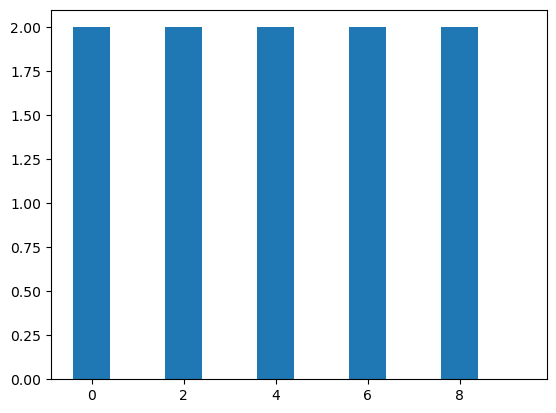

In [365]:
# Instantiate a new my_hasher object with defaults for size and hash_method
m = my_hasher()
# Hash the default data 
m.hash_data(range(0, 20, 2))
# Bar plot showing number of hits per array bin
m.plot()


### An interlude on `entropy`

The `entropy` function quantifies the average amount of 'surprise'
when sampling from a given set of outcomes. The surrounding `np.exp()`
and division by the number of potential states (`self.size`) rescale
the results to the unit interval ([0, 1]) which represents the `evenness`
of distribution of index values. In the limit of no variation
among hash values evenness is 0 (right), and with perfect uniformity
evenness will be 1 (left). These are cartoon examples, and no hash function
will ever achieve exactly perfect evenness but it's a nice goal.

*"Painters, do not fear perfection. You will never achieve it!"*. 
― Salvador Dalí, [The Paintings 1904-1946, Volume 1](https://www.google.com/books/edition/Salvador_Dal%C3%AD_1904_1989/AnRWAAAAYAAJ?hl=en)

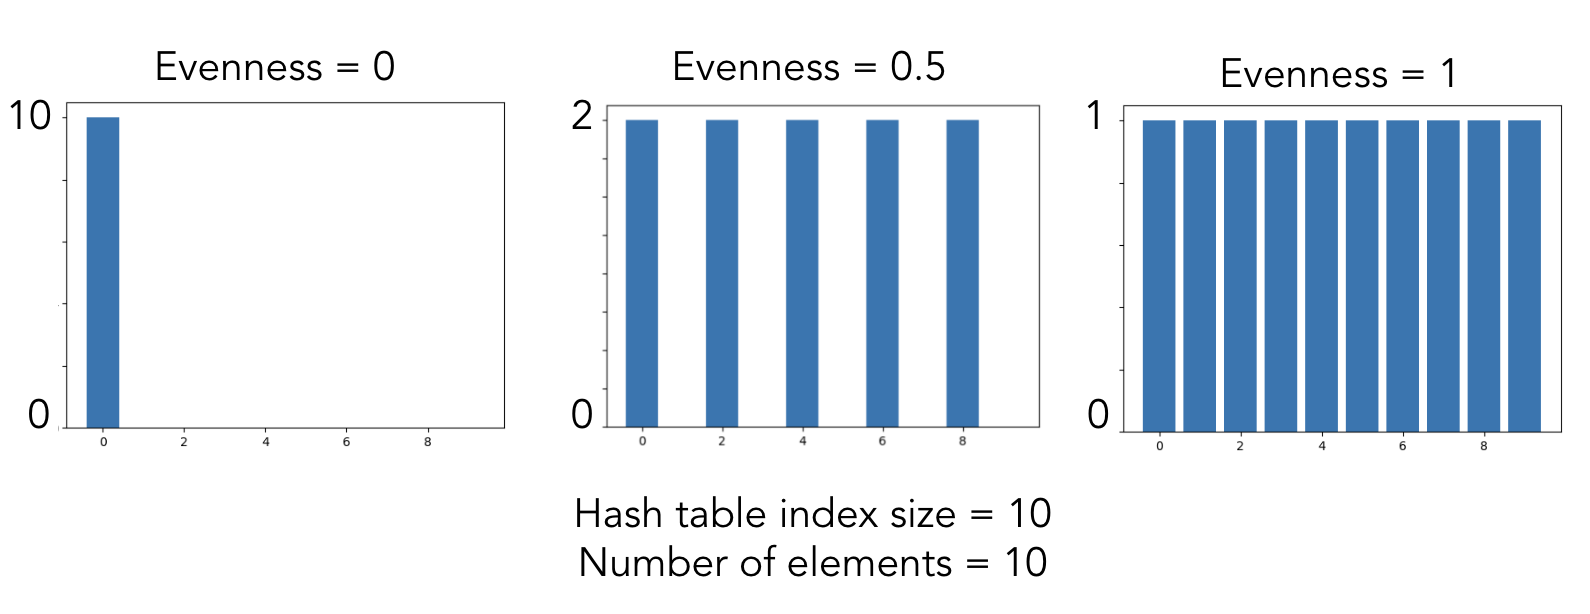

[2, 2, 14, 6, 9, 12, 7, 9, 3, 5]


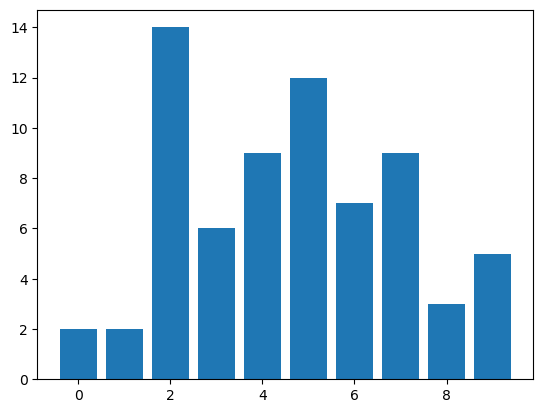

In [303]:

def hash_length(data):
    data = str(data)
    return len(data)

def hash_first(data):
    data = str(data)
    print(data)
    return ord(data[0])

def hash_sum(data):
    data = str(data)
    return sum([ord(x) for x in data])

size = 10
indices = [0] * size

for word in lorem_text:
    hash_code = hash_length(word) % size
    indices[hash_code] += 1

print(indices)
_ = plt.bar(range(size), indices)

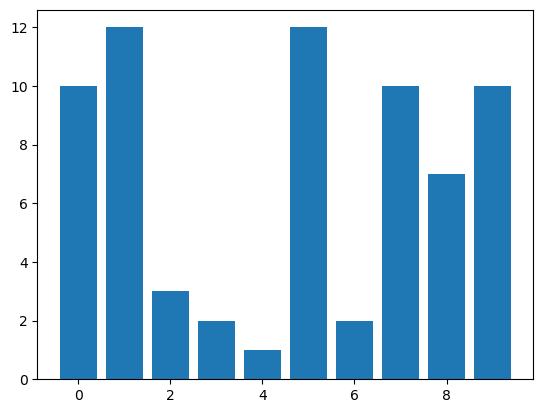

In [302]:
size = 10
indices = [0] * size

for word in lorem_text:
    hash_code = hash_first(word) % size
    indices[hash_code] += 1
_ = plt.bar(range(size), indices)

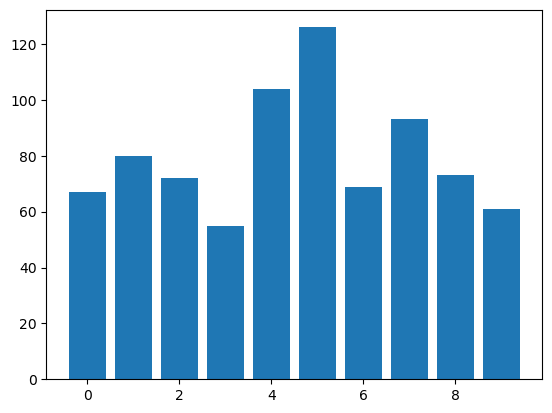

In [208]:
size = 10
indices = [0] * size

for word in lorem_text:
    hash_code = hash_sum(word) % size
    indices[hash_code] += 1
_ = plt.bar(range(size), indices)

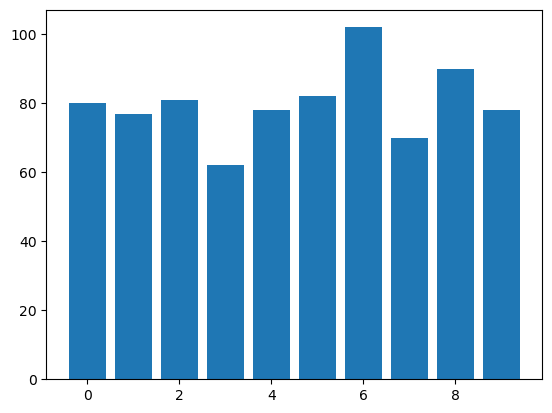

In [209]:
size = 10
indices = [0] * size

for word in lorem_text:
    hash_code = hash(word) % size
    indices[hash_code] += 1
_ = plt.bar(range(size), indices)

In [214]:
from scipy.stats import entropy

np.exp(entropy(indices))/size

np.float64(0.9920705138308016)

In [217]:
class my_hash_test:
    def __init__(self, size=10, hash_method=hash):
        self.size = size
        self.indices = [0] * size
        self.hash_method = hash_method

    def hash_data(self, data):
        for item in data:
            hash_val = self.hash_method(item) % self.size
            self.indices[hash_val] += 1

    def evenness(self):
        return np.exp(entropy(self.indices))/self.size

    def plot(self):
        plt.bar(range(self.size), self.indices)

0.8517538380636649
[4, 11, 11, 7, 15, 15, 12, 11, 0, 14]


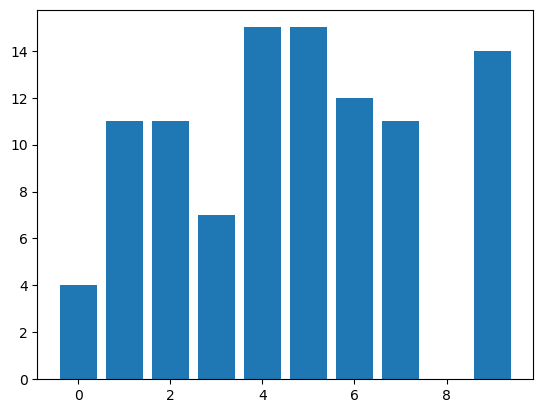

In [301]:
test = my_hash_test(hash_method=hash_first)
test.hash_data(np.random.randint(0, 10000, 100))
print(test.evenness())
print(test.indices)
test.plot()


# Understanding python dictionary resizing

In [236]:
import sys

d = dict()
sys.getsizeof(d)

64

In [274]:
d = dict()
length = 8

for i in range(1, 50):
    pre_size = sys.getsizeof(d)
    d[i] = 1
    post_size = sys.getsizeof(d)
    if pre_size != post_size & pre_size != 64:
        length = length * 2
    print(f"Elements {i}\tload factor {i/length:.4f}", end="\t")
    print(f"size (bytes) {post_size}")


Elements 1	load factor 0.1250	size (bytes) 224
Elements 2	load factor 0.2500	size (bytes) 224
Elements 3	load factor 0.3750	size (bytes) 224
Elements 4	load factor 0.5000	size (bytes) 224
Elements 5	load factor 0.6250	size (bytes) 224
Elements 6	load factor 0.3750	size (bytes) 352
Elements 7	load factor 0.4375	size (bytes) 352
Elements 8	load factor 0.5000	size (bytes) 352
Elements 9	load factor 0.5625	size (bytes) 352
Elements 10	load factor 0.6250	size (bytes) 352
Elements 11	load factor 0.3438	size (bytes) 632
Elements 12	load factor 0.3750	size (bytes) 632
Elements 13	load factor 0.4062	size (bytes) 632
Elements 14	load factor 0.4375	size (bytes) 632
Elements 15	load factor 0.4688	size (bytes) 632
Elements 16	load factor 0.5000	size (bytes) 632
Elements 17	load factor 0.5312	size (bytes) 632
Elements 18	load factor 0.5625	size (bytes) 632
Elements 19	load factor 0.5938	size (bytes) 632
Elements 20	load factor 0.6250	size (bytes) 632
Elements 21	load factor 0.6562	size (bytes) 632
E

In [ ]:
# Determine the element insertion number that will trigger the next index resize

In [277]:
128 * 2/3

85.33333333333333

In [244]:
# Good
d = dict()
length = 8
nbytes = 224
for i in range(1, 100):
    d[i] = i
    tmp = sys.getsizeof(d)
    if tmp != nbytes:
        length = length * 2
        nbytes = tmp
    print(f"Elements {i} - load {i/length:.2f}", end="\t\t")
    print(nbytes, end="\n")


Elements 1 - load 0.12		224
Elements 2 - load 0.25		224
Elements 3 - load 0.38		224
Elements 4 - load 0.50		224
Elements 5 - load 0.62		224
Elements 6 - load 0.38		352
Elements 7 - load 0.44		352
Elements 8 - load 0.50		352
Elements 9 - load 0.56		352
Elements 10 - load 0.62		352
Elements 11 - load 0.34		632
Elements 12 - load 0.38		632
Elements 13 - load 0.41		632
Elements 14 - load 0.44		632
Elements 15 - load 0.47		632
Elements 16 - load 0.50		632
Elements 17 - load 0.53		632
Elements 18 - load 0.56		632
Elements 19 - load 0.59		632
Elements 20 - load 0.62		632
Elements 21 - load 0.66		632
Elements 22 - load 0.34		1168
Elements 23 - load 0.36		1168
Elements 24 - load 0.38		1168
Elements 25 - load 0.39		1168
Elements 26 - load 0.41		1168
Elements 27 - load 0.42		1168
Elements 28 - load 0.44		1168
Elements 29 - load 0.45		1168
Elements 30 - load 0.47		1168
Elements 31 - load 0.48		1168
Elements 32 - load 0.50		1168
Elements 33 - load 0.52		1168
Elements 34 - load 0.53		1168
Elements 3

# Hash table in python

In [362]:
class HashTable:
    def __init__(self, size=10):
        self.size = size
        self.table = [[] for _ in range(size)]  # Create a list of empty lists (chaining)

    def __repr__(self):
        """Display the current state of the hash table."""

    def _hash(self, key):
        """Generate a hash index using Python's built-in hash function."""
        return hash(key) % self.size

    def put(self, key, value):
        """Insert a key-value pair into the hash table."""
        index = self._hash(key)
        for pair in self.table[index]:
            if pair[0] == key:
                pair[1] = value  # Update value if key already exists
                return
        self.table[index].append([key, value])  # Append new key-value pair

    def get(self, key):
        """Retrieve a value by key."""
        index = self._hash(key)
        for pair in self.table[index]:
            if pair[0] == key:
                return pair[1]  # Return the value if key is found
        return None  # Key not found

    def remove(self, key):
        """Remove a key-value pair from the hash table."""
        index = self._hash(key)
        for i, pair in enumerate(self.table[index]):
            if pair[0] == key:
                del self.table[index][i]
                return True
        return False  # Key not found

    def display(self):
        """Display the current state of the hash table."""
        for i, bucket in enumerate(self.table):
            print(f"Bucket {i}: {bucket}")
ht = HashTable(10)
ht.put(1, 1)
ht

TypeError: __repr__ returned non-string (type list)

### Numpy arrays
Numpy arrays are efficient for storing and operating on sets of values that are all of the same `dtype`. 

In [ ]:
# default type is float64 (large)
arr = np.zeros(10)
print(arr)
print(arr.dtype)
print(arr.nbytes)

In [ ]:
# default int type is int64 (large)
arr = np.zeros(10, dtype=int)
print(arr)
print(arr.dtype)
print(arr.nbytes)

In [ ]:
# smaller int types are faster and use less memory (1/4 of the above example)
arr = np.zeros(10, dtype=np.int16)
print(arr)
print(arr.dtype)
print(arr.nbytes)

In [ ]:
# smaller int types are faster and use less memory (1/8 of the above example)
arr = np.zeros(10, dtype=np.int8)
print(arr)
print(arr.dtype)
print(arr.nbytes)

The default numeric types are int64 and float64, which are able to hold super super large numbers. But, they take up large amounts of memory too. In general, who cares, memory is cheap. But, when you're writing code for performance, it turns out that using smaller dtypes can make your code much much faster. For example, if your data is always composed of only 4 values (e.g., think of DNA which is only 4 characters) then you do not need to use a dtype that is so much larger. The danger of using a small dtype is that you can experience 'overflow' if your values do exceed the capacity of the dtype. For example, int8 can only store values in -128 to 128. When this happens you get strange results that will cause big errors in your analyses! This is why the default is to use large dtypes (like np.int64).

To keep things simple when you're first starting to learn numpy you could just always use the default dtype when working with numeric data (np.float64). But it is good to be aware of dtypes since understanding these will help you to become a power user.

In [ ]:
# max int8 is 128 (uh oh, it starts counting down after 127!)
arr = np.zeros(10, dtype=np.int8)
arr[:] = range(125, 135)
print(arr)


To keep things simple when you're first starting to learn numpy you could just always use the default dtype when working with numeric data (np.float64). But it is good to be aware of dtypes since understanding these will help you to become a power user.

### Modifying arrays (a copy versus a view)

Although arrays seem similar to lists, they are in fact very different and you will likely run in to many errors early on due to this confusion. Arrays can be indexed and sliced like lists, and they are also mutable, so that you can change values within an array like in a list. However, they differ in operations like broadcasting (e.g., + 1 will add 1 value to all elements of an array but not a list), and they obviously have very different functions and attributes.

Another difference that it is important to be aware of it that they return a different type of object when you <b>slice</b> an array versus a list. This topic may seem like a minor detail, but it is a common 'gotcha', and so a good thing to try to comprehend. 

Essentially, arrays are intended to store only a single copy of itself in memory unless you *explicitly* tell it to make another copy by using the `.copy()` function. Otherwise, the thing that is returned to you when you perform a slice on an array is called a `view` (a view of the same object). If you modify a view of an array object then you will have modified the original array object as well. 

Lists on the other hand return a copy of themselves when you index or slice them, such that the original is unchanged if you operate on the copy. This is demonstrated below. First I show that mutating a single indexed value is not a problem. They behave the same. It is only when slicing that this difference arises.

In [ ]:
# mutate the first element in a list
ll = ['a', 'b', 'c']
ll[0] = 'd'
print(ll)

In [ ]:
# mutate the first element in an array
arr = np.array(['a', 'b', 'c'])
arr[0] = 'd'
print(arr)

In [ ]:
# make a copy of a list and mutate it, both exist as separate instances
lc = ll.copy()
lc[0] = 'e'
print(lc, ll)

In [ ]:
# make a copy of an array and mutate it, both exist as separate instances
carr = arr.copy()
carr[0] = 'e'
print(carr, arr)

So far so good. Nothing unexpected happened. But now you will see how they act differently:

In [ ]:
# make a copy of list by slicing, mutate first element, and compare: they are different
lsub = ll[:2]
lsub[0] = 'x'
print(lsub, ll)

In [ ]:
# make a view of array by slicing, mutate first element, and compare: they are same!
asub = arr[:2]
asub[0] = 'x'
print(asub, arr)

In [ ]:
# to get a copy of the array we need to call .copy() explicitly!
asub = arr[:2].copy()
asub[0] = 'y'
print(asub, arr)

## Genomic sequence data as an array
The string characters A,C,G,T can be sampled in an array to represent a sequence of DNA. Here we use the `.random` module of numpy, which is similar to the `.random` package from the standard library, but much more powerful, as it return arrays and has many more scientific methods for sampling random distributions, as we'll see. The array of sequence data in this case is six rows and 12 columns, or in other words, we have data for 6 haploid individuals for 12 sites of DNA. 

In [ ]:
seq = np.random.choice(list("ACGT"), size=10, replace=True)  # make array that is 12 bases long
seqs = np.array([seq] * 6)                                   # make 6 copies of arr

In [ ]:
print(seqs)

### Fancy indexing

In [ ]:
# select the first four rows
seqs[:4, :]

In [ ]:
# select the last six columns
seqs[:, -6:]

In [ ]:
# select first two rows and first four columns
seqs[:2, :4]

In [ ]:
# create boolean mask of whether element is "G"
seqs == "G"

In [ ]:
# view the boolean mask as int8 values (easier to read than True/False)
np.int8(seqs == "G")

In [ ]:
# create boolean mask for whether any sites in a column are "G"
np.any(seqs == "G", axis=0)

# Generate variable sequence data

Don't worry too much about this function for right now, we'll dive into it in detail in the next notebook. For now we'll just use it to generate variable sequence data. 

In [ ]:
def seqdata(ninds, nsites, seed=None):
    """
    Generate a ninds x nsites array of A,C,T,G string data
    and randomly add mutations to some sites.
    """
    # use random seed
    np.random.seed(seed)
    
    # make sequence data 
    oseq = np.random.choice(list("ACGT"), size=nsites)
    arr = np.array([oseq] * ninds)
    
    # introduce some mutataions
    muts = np.random.binomial(1, 0.1, (ninds, nsites))
    for col in range(nsites):
        newbase = np.random.choice(list(set("ACTG") - set(arr[0, col])))
        mask = muts[:, col].astype(bool)
        arr[:, col][mask] = newbase
    return arr

In [ ]:
# generate an array of variable sequence data
arr = seqdata(8, 10, 12345)
print(arr)

### Find variable sites
Here we can use a broadcasting method to compare sequences to find if there is any variation in the sequences. We could examine each column individually and count the number of elements in it, but a much easier way is to simply perform on operation over an `axis` of the array that will return True or False depending on whether there is variation. One way is to simply compare each column to the value in the first row. Broadcasting will allow this to work so that across all rows each value in each column is compared to its respective first row element. 

Look at the boolean array below and the array above to see how it is identifying the columns that contain variation (columns where all elements are not the same as the first row). Complex tasks like this can be made very simple by learning how to think in terms of array operations.

In [ ]:
# ask which sites are variable
print(arr != arr[0])

### Using *any* and *all*
These are commonly used operations to select or mask parts of an array based on a boolean comparison. Below we call `.any()` on a boolean array. The operation `arr != arr[0]` returns the boolean array shown above (all True or False values). The `.any()` function will return True if the value is True. By telling it to work over an axis we are asking it to tell us if *any* of the values in a given column are True. From looking at the array above we can see that some are and some aren't. We expect to get a result that includes a True or False statement for each column. Thus, by operating over the array with an axes argument we expect the *dimension* of the result to be less than the original array (i.e., the shape of arr is (8,10) and the shape of the result below is (10,)). 

In [ ]:
# broadcast with any() to get columns (sites) that are variable
np.any(arr != arr[0], axis=0)

## Masking (filtering)

Here we will use masking through an example for calculating population genetic statistics from a sequence array.

Often we are interested in filtering sequence data based on some criterion before we calculate statistics on it. Examples would be filtering to remove sites with missing data (often coded in DNA by the character `N`), or filtering to remove sites with rare alleles (if its found in very few individuals it may just be an error). The latter is often applied with a filter called a minor allele frequency (MAF). Let's practice calculating the minor allele frequency and filtering based on it. 

In [ ]:
# generate a larger array of variable sequence data
arr = seqdata(16, 10, 12345)
print(arr)

### calculate the frequency of the rare allele in each column
Let's think about how to do this. First, we need to find the sites that are variable in each column, then we need to find a way to count them, and then divide by the length of the column to get the value as a frequency. Well, all of this information is present in the operations we performed above to find the variable sites. Let's use that same framework here. 

#### 1. view which sites are variable?

In [ ]:
# comparison returns True or False for every value (shown as ints for easier viewing here)
np.int8(arr != arr[0])

#### 2. get each column as a frequency
Try to tease apart what each part is doing here. Open a new jupyter cell below and execute parts of the code. What is returned by the sum function? What is the shape[0]? Try to figure it out by exploring.

In [ ]:
# get sum of each column in array from above. Divide each column sum by the column length.
np.sum(arr != arr[0], axis=0) / arr.shape[0]

#### 3. to get the minor allele frequency

In [ ]:
# store view from above cell
freqs = np.sum(arr != arr[0], axis=0) / arr.shape[0]

# store a copy so we do not modify the original array 'arr'
maf = freqs.copy()

# subselect sites with freq (>0.5) and modify to be 1-value (so it is a MINOR freq)
maf[maf > 0.5] = 1 - maf[maf > 0.5]

# print minor allele frequencies
print(maf)

#### 4. filter columns of the array by MAF
For our analyses we might only want to analyze sites with a MAF > 0.1. This excludes two sites from the original array, one that was not variable and one that was variable at only a single haplotype. 

In [ ]:
print(arr[:, maf > 0.1])

<div class="alert alert-success">
    Congrats you have finished the notebook. There is not assessment here, move on the next notebook. It is OK if you found this part challenging. It will take some time to become comfortable with the numpy notation. But be sure to practice as you go by dissecting these statements and running them bit by bit in your notebook.
</div>